# Lab 6: Convolutional Network Architectures
## by Michael Doherty, Leilani Guzman, and Carson Pittman

Link to the dataset: https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set

## 1. Preparation
### 1.1 Performance Metric

In [1]:
import glob
import warnings
from tensorflow.keras.preprocessing.image import load_img, img_to_array

warnings.simplefilter('ignore')

# load in images and labels as numpy arrays
images_and_labels = []

#FIXME just make 2 separate lists later, make labels 0/1 by default??
# FIXME should we make images grayscale??

for filename in glob.glob('data/vehicles/*.png'):
    img = load_img(filename)
    img_array = img_to_array(img)
    
    images_and_labels.append(tuple((img_array, 'vehicle')))
    

for filename in glob.glob('data/non-vehicles/*.png'):
    img = load_img(filename)
    img_array = img_to_array(img)
    
    images_and_labels.append(tuple((img_array, 'non_vehicle')))
    

print('There are', len(images_and_labels), 'images')

There are 17760 images


Now that we've read in the images, let's visualize the distribution of labels for our images.

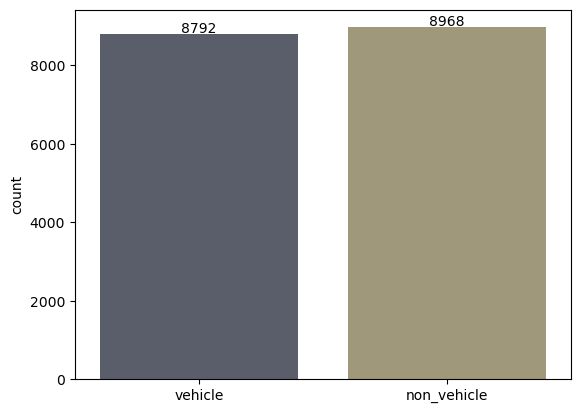

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(x=[label for _, label in images_and_labels], palette='cividis')

for bar in ax.patches:
    ax.annotate(f'{bar.get_height():.0f}', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.xticks([0,1], ['vehicle', 'non_vehicle'])
plt.show()

As we can see, there are about the same number of instances for each label (<code>non_vehicle</code> has a little less than 200 more instances than <code>vehicle</code>). **ADD MORE**

**Dr. Larson said accuracy would be a pretty good metric, as we care about both vehicle and non_vehicle labels (since the business case is self-driving cars, and the images seem to be taken from a car driving on the road, so we would want it to be able to accurately distinguish between the two)**

**Probably should mention somewhere that these images are like a 'patchwork', i.e., they seem to be taken from a larger image that was captured by a car driving on the road**

### 1.2 Training and Testing Method

**Dr. Larson said we don't specifically need to stratify, as the splits will be pretty consistent since the labels are pretty balanced**

**He said this dataset is one of those weird ones where accuracy and not stratifying is actually probably the best solution**

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

X = [image for image, _ in images_and_labels]
y = [0 if label == 'vehicle' else 1 for _, label in images_and_labels]

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2)

# normalize pixel values and mean shift
X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5

## 2. Modeling
### 2.1 Data Augmentation
Now that we've defined our performance metric and created training and testing splits for cross validation, let's start creating our Convolutional Neural Networks! Let's start by creating a base for our models that includes some augmentation layers.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomBrightness

model_base = Sequential()

model_base.add(RandomFlip("horizontal"))
model_base.add(RandomRotation(0.2))
model_base.add(RandomZoom(0.2))
model_base.add(RandomBrightness(0.2))

**Dr. Larson said these Augmentation layers should be used for all of our models (i.e., we shouldn't change them after we initialize them, as it will make comparing models weird)**

**Dr. Larson also said that the 2 big augmentations we don't want to do are RandomFlip("vertical") and randomly rotating by too high a percentage (as even after augmentation, the images should still be something a car could realistically see while driving around on the road, and upside down or sideways cars would not be something the car would see)**

**Justification would be something like: A little bit of random rotation, as cars might be driving up a hill, changing brightness, as cars could be driving at different times of day with different lighting, etc.**

Explain why these augmentation features are appropriate...

### 2.2 Model Creation
Now let's create a few different models using the base structure we just created.

#### 2.2.1 CNN 1: Basic Network

In [5]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_1 = clone_model(model_base)


# The following was copied from Dr. Larson's Notebook (12. More Advanced CNN Techniques)
NUM_CLASSES = 2
img_wh = 64

# let's start with an AlexNet style convolutional phase
cnn_1.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn_1.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn_1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn_1.add(Flatten())
cnn_1.add(Dense(128, activation='relu'))
cnn_1.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn_1.add(Dense(1, activation='sigmoid'))

# Let's train the model 
cnn_1.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

history_1 = cnn_1.fit(X_train, y_train, batch_size=32, 
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test)
                  )

Epoch 1/5
444/444 [==============================] - 62s 132ms/step - loss: 2.5074 - accuracy: 0.5020 - val_loss: 0.7290 - val_accuracy: 0.5284
Epoch 2/5
444/444 [==============================] - 76s 171ms/step - loss: 0.7237 - accuracy: 0.5018 - val_loss: 0.8496 - val_accuracy: 0.5248
Epoch 3/5
444/444 [==============================] - 74s 166ms/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.8498 - val_accuracy: 0.5248
Epoch 4/5
444/444 [==============================] - 68s 152ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.8496 - val_accuracy: 0.5248
Epoch 5/5
444/444 [==============================] - 68s 154ms/step - loss: 0.6931 - accuracy: 0.5036 - val_loss: 0.8513 - val_accuracy: 0.5251


**Might be able to get rid of all the warnings by upgrading Tensorflow version**

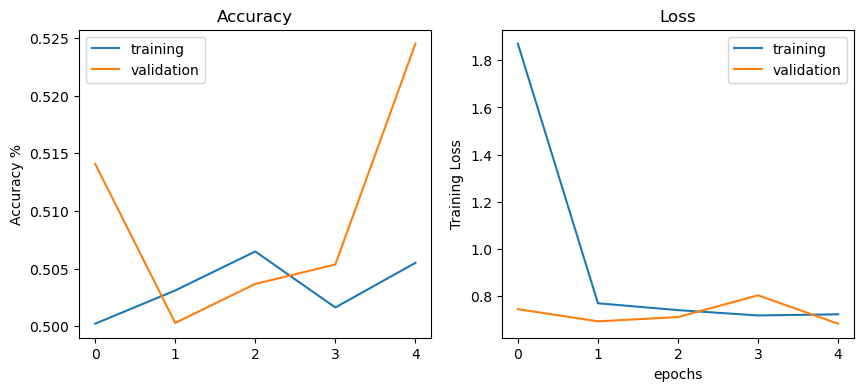

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history_1.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_1.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_1.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

#### 2.2.2 CNN 2: Ensemble Network

In [28]:
from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2 

num_ensembles = 3
l2_lambda = 0.0001 # notebook was 0.000001

input_holder = Input(shape=(img_wh,img_wh,3))
print(input_holder.shape)


# Start with a convolutional layer
x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu', data_format='channels_last')(input_holder)

x = Conv2D(filters=32,
            kernel_size=(3,3),
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(l2_lambda),
            padding='same',
            activation='relu')(x)

input_conv = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

branches = []
for _ in range(num_ensembles):
    # Start using NiN (MLPConv)
    x = Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(input_conv)
    
    x = Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='relu', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    x = Conv2D(filters=64,
                input_shape = (img_wh, img_wh, 1),
                kernel_size=(3,3),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                padding='same',
                activation='linear', data_format='channels_last')(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

    # Add layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # Add dropout for regularization after convolution layers
    x = Dense(64,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    x = Dense(NUM_CLASSES,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda))(x)
    
    # Now add this branch to the master list
    branches.append(x)

x = concatenate(branches)

x = Dense(1,
        activation='sigmoid',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=l2(l2_lambda))(x)

# Setting the network using functional API
cnn_ens = clone_model(model_base)
cnn_ens = Model(inputs=input_holder, outputs=x)
cnn_ens.summary()

cnn_ens.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam',
                metrics=['accuracy'])

history_2 = cnn_ens.fit(X_train, y_train, batch_size=32,
                        steps_per_epoch=int(len(X_train)/128), 
                        epochs=5, verbose=0,
                        validation_data=(X_test,y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                        )

(None, 64, 64, 3)
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_86 (Conv2D)             (None, 64, 64, 32)   896         ['input_20[0][0]']               
                                                                                                  
 conv2d_87 (Conv2D)             (None, 64, 64, 32)   9248        ['conv2d_86[0][0]']              
                                                                                                  
 max_pooling2d_42 (MaxPooling2D  (None, 32, 32, 32)  0           ['conv2d_87[0][0]']              
 )                                                                       

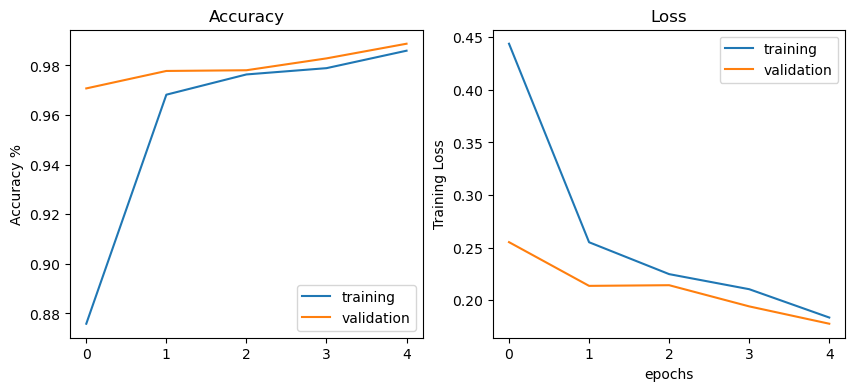

In [29]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_2.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history_2.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_2.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_2.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

### 2.3 Model Visualization and Comparison

### 2.4 Convolutional Network vs. Multi-Layer Perceptron

## 3. Transfer Learning
### 3.1 Transfer Learning Model

### 3.2 Model Comparison